In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together



#### <font color='purple'> [Define data frame](#1)
#### <font color='purple'> [Rdisk, Mass and Halo Spin plot](#2)
#### <font color='purple'> [Normalize the Dataset (similar to v7 Notebook for Old SAM, TNG-SAM,dataset or similar to v1 Notebook of TNG300-NewSAM)](#3)
#### <font color='purple'> [Save the Normalized, Complete data set and use it in the next version of the notebook](#4)
#### <font color='purple'> [Disks SR eqn Spin/NormVdisk^2 applied on predicting Rdisk/Rhalo rather than R50/Rhalo (NormHalfRadius)](#5)
#### <font color='purple'> [Definition of Morphologies for Rdisk, Rbulge predict dataset & Save Dataset ](#6)
#### <font color='purple'> [ ](#7)

### Define functions

In [2]:
def log_mass_size(df):
    '''
    Converts to log10 non-zero size and mass entries (without distinguishing galaxy type)
    output: df with new columns of log mass, log size added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
#     df=df[(df['GalpropMstar'] > 0) & (df['HalopropMhot'] > 0)]
#     df=df[df['GalpropMbulge'] >= 0]

#     #subhalo_flag = subhalos[‘SubhaloFlag’]
#     if type_of_galaxy == 'central':
#         df=df[df['subhalo_flag']==True]
#     elif type_of_galaxy == 'satellite':
#         df=df[df['subhalo_flag']==False]
#     else: 
#         print("type_of_galaxy must be set to central or satellite")

    #since we got rid of all zero mass we can just take the log10
    df.loc[:,'GalpropLogMstar']=np.log10(df.loc[:,'GalpropMstar'])
    df.loc[:,'GalpropLogHalfRadius']=np.log10(df.loc[:, 'GalpropHalfRadius'])
    df.loc[:,'HalopropLogMvir']=np.log10(df.loc[:,'HalopropMvir'])
    df.loc[:,'HalopropLogMhot']=np.log10(df.loc[:,'HalopropMhot'])
    df.loc[:,'GalpropLogMbulge']=df.loc[:,'GalpropMbulge'].apply(lambda x: np.log10(x) if x>0 else 0)

    return df

In [3]:
def log_SFR(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR added to it

    '''
    #first let's remove all galaxy_mass=0 since you are going to at the end anyway
    df=df[df['sfr'] > 0]

    #since we got rid of all zero mass we can just take the log10
    df['sfr_log']=np.log10(df['sfr'])

    return df

In [4]:
# function to return the base 10 logarithm of non-zero values
def return_log(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return 0

In [5]:
# function to return the base 10 logarithm of non-zero values
def return_log_SFR(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return -2

In [6]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [7]:
def log_sfr(df):
    '''
    Converts to log10 non-zero SFR entries (without distinguishing galaxy type)
    output: df with new columns of log SFR

    '''
    df.loc[:,'GalpropLogSfr']=df.loc[:,'GalpropSfr'].apply(lambda x: np.log10(x) if x>0 else 0)
    df.loc[:,'GalpropLogSfrave100myr']=df.loc[:,'GalpropSfrave100myr'].apply(lambda x: np.log10(x) if x>0 else 0)
    df.loc[:,'GalpropLogSfrave1gyr']=df.loc[:,'GalpropSfrave1gyr'].apply(lambda x: np.log10(x) if x>0 else 0)
    df.loc[:,'GalpropLogSfrave20myr']=df.loc[:,'GalpropSfrave20myr'].apply(lambda x: np.log10(x) if x>0 else 0)

    return df

In [8]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

## <font color='blue'> <a id =1> </a> <br> Define data frame

In [9]:
import os
# os.mkdir('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset')

In [37]:
# Raw dataset from TNG300 Notebook v1,
# the version of dataset without non-physical galaxies whose Mstar/Mvir (GalpropNormMstar) > 0.2,
# and with stellar mass cut at log10Mstar>9.0
# and without (fdisk<0.02 and disk) galaxies
# and with Spin_effective, where all Spin<0.02 are set to equal to 0.02 (dataset saved in TNG300 Notebook v6)
df_not_normalized = pd.read_csv('TNG300-SAM_images/v6_TNG300-SAM_Morphologies_definition/v6_TNG300-NewSAM_Raw_Dataset_fromv1_wo_nonphys_mstar9_and_diskgals_w_smallfdisk_w_spineff.csv')

In [11]:
df_not_normalized.shape

(207467, 59)

In [12]:
df_not_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot_radio', 'GalpropMbulge', 'GalpropMcold', 'GalpropMstar',
       'GalpropMstar_merge', 'GalpropMstrip', 'GalpropMu_merger',
       'GalpropMvir', 'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal',
       'GalpropRbulge', 'GalpropRdisk', 'GalpropRhalo', 'GalpropSfr',
       'GalpropSfrave100myr', 'GalpropSfrave1gyr', 'GalpropSfrave20myr',
       'GalpropSigmaBulge', 'GalpropTmerger', 'GalpropTmerger_major',
       'GalpropTsat', 'GalpropVdisk', 'GalpropZcold', 'GalpropZstar',
       'HalopropC_nfw', 'HalopropMaccdot_pristine', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMass_ejected',
       'HalopropMcooldot', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropZhot', 'GalpropVvir',
       'GalpropMdisk', 'GalpropHalfRadius', 'HalopropVvir', 'GalpropLogMstar',
       'GalpropLogHalfRadius

### <font color='darkviolet'> <a id =2> </a> <br>Rdisk, Mass and Halo Spin plot

In [13]:
mass_Rdisk_corr = round(stats.spearmanr(df_not_normalized['GalpropLogMstar'], 
                                               df_not_normalized['GalpropRdisk'])[0], 2)
SFR_Rdisk_corr = round(stats.spearmanr(df_not_normalized['GalpropLogSfr'], 
                                              df_not_normalized['GalpropRdisk'] )[0], 2)
SFR_Rdisk_corr = round(stats.spearmanr(df_not_normalized['GalpropLogSfr'], 
                                              df_not_normalized['GalpropLogMstar'] )[0], 2)
mom_Rdisk_corr = round(stats.spearmanr(df_not_normalized['HalopropSpin'], 
                                              df_not_normalized['GalpropRdisk'])[0], 2)
print('mass_Rdisk_corr:', mass_Rdisk_corr)
print('SFR_Rdisk_corr:', SFR_Rdisk_corr)
print('SFR_Rdisk_corr:', SFR_Rdisk_corr)
print('mom_Rdisk_corr:', mom_Rdisk_corr)

mom_size_corr = round(stats.spearmanr(df_not_normalized['HalopropSpin'], 
                                              df_not_normalized['GalpropHalfRadius'])[0], 2)
print('mom_size_corr:', mom_size_corr)

print('Rdisk and Halfmass Radius correlation with spin is the same, ~0.7.')

mass_Rdisk_corr: 0.18
SFR_Rdisk_corr: 0.38
SFR_Rdisk_corr: 0.38
mom_Rdisk_corr: 0.68
mom_size_corr: 0.69
Rdisk and Halfmass Radius correlation with spin is the same, ~0.7.


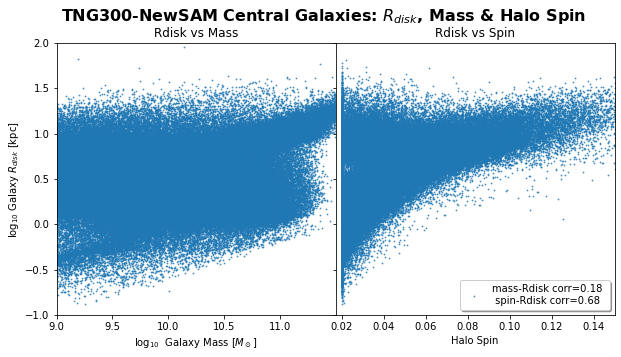

In [14]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(10,5))
fig.suptitle(r'TNG300-NewSAM Central Galaxies: $R_{disk}$, Mass & Halo Spin  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

im1 = ax1.scatter(df_not_normalized['GalpropLogMstar'], np.log10(df_not_normalized['GalpropRdisk']), 
                    s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7 , vmin=-2, vmax=1.0)#, label=label)

ax1.set_xlim([9.0, 11.5])
ax1.set_xticks([9.0, 9.5, 10.0, 10.5, 11.0])
ax1.set_ylim([-1.0,2.0])
ax1.set_title('Rdisk vs Mass')
ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_ylabel('$\log_{10} $ Galaxy $R_{disk}$ [kpc] ')
# ax1.legend(loc='lower right', shadow=True)


label = 'mass-Rdisk corr={} \n spin-Rdisk corr={}'.format(mass_Rdisk_corr, mom_Rdisk_corr )
im2 = ax2.scatter(df_not_normalized['HalopropSpin'], np.log10(df_not_normalized['GalpropRdisk']), 
                     s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)
#                   c = (df_log_mass_filtered['GalpropLogSfr']),  s=3, marker='.', alpha=0.7,label= label, vmin=-2, vmax=1.0)

ax2.set_xlim([0.017,0.15])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
ax2.set_title('Rdisk vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='lower right' , shadow=True)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_centrals_Mass_Rdisk_AngMom.jpeg", dpi=500)
plt.show()

## <font color='purple'> <a id =3> </a> <br> Normalize the Dataset (similar to v7 Notebook for Old SAM, TNG-SAM,dataset or similar to v1 Notebook of TNG300-NewSAM)

#### <font color='indigo'> Drop the not needed columns

In [38]:
df_not_normalized.shape

(207467, 59)

In [16]:
df_not_normalized.columns.to_list()

['GalpropMBH',
 'GalpropMH2',
 'GalpropMHI',
 'GalpropMHII',
 'GalpropMaccdot_radio',
 'GalpropMbulge',
 'GalpropMcold',
 'GalpropMstar',
 'GalpropMstar_merge',
 'GalpropMstrip',
 'GalpropMu_merger',
 'GalpropMvir',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropRbulge',
 'GalpropRdisk',
 'GalpropRhalo',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropSigmaBulge',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropTsat',
 'GalpropVdisk',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMass_ejected',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropMhot',
 'HalopropMstar_diffuse',
 'HalopropMvir',
 'HalopropZhot',
 'GalpropVvir',
 'GalpropMdisk',
 'GalpropHalfRadius',
 'HalopropVvir',
 'GalpropLogMstar',
 'GalpropLogHalfRadius',
 'HalopropLogMvir',
 'HalopropLogMhot',
 'GalpropLogMbulge',
 'GalpropLogSfr',
 'Galprop

In [17]:
df_not_normalized=df_not_normalized.drop(columns =['GalpropTsat',
                                               'GalpropLogMstar', 'GalpropLogHalfRadius', 'HalopropLogMvir',
                                               'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr',
                                               'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
                                               'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass',
                                               'Galprop_baryon_mass', 'Galprop_gas_fraction',
                                               'GalpropVvir', 'GalpropMvir'])

In [18]:
df_not_normalized.shape

(207467, 44)

In [19]:
df_not_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot_radio', 'GalpropMbulge', 'GalpropMcold', 'GalpropMstar',
       'GalpropMstar_merge', 'GalpropMstrip', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropRbulge',
       'GalpropRdisk', 'GalpropRhalo', 'GalpropSfr', 'GalpropSfrave100myr',
       'GalpropSfrave1gyr', 'GalpropSfrave20myr', 'GalpropSigmaBulge',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropVdisk',
       'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_pristine', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMass_ejected',
       'HalopropMcooldot', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropZhot', 'GalpropMdisk',
       'GalpropHalfRadius', 'HalopropVvir', 'MstarMvir_ratio',
       'BulgeMstar_ratio', 'DiskMstar_ratio', 'HalopropSpin'],
      dtyp

### Normalize the dataset by dividing masses by Mhalo and size by Rhalo


In [20]:
def normalization_func(df_old):
    '''
    Normalizes the dataset by dividing all masses (but not mass/time ratios)
    by halo mass, and galaxy size by halo size

    '''
#     could also use the method below
#     df_log_mass_filtered.loc[:,'GalpropNormMstar']=df_log_mass_filtered.loc[:,'GalpropMstar'].div(df_log_mass_filtered.HalopropMvir, axis=0)
    df = df_old.copy()
    
    halomass=df.loc[:,'HalopropMvir']
    halorad= df.loc[:,'GalpropRhalo']
    
    df.loc[:,'GalpropNormHalfRadius']=df.loc[:,'GalpropHalfRadius']/halorad
    df.loc[:,'GalpropNormRdisk']=df.loc[:,'GalpropRdisk']/halorad
    df.loc[:,'GalpropNormRbulge']=df.loc[:,'GalpropRbulge']/halorad

    df.loc[:,'GalpropNormRhalo']=df.loc[:,'GalpropRhalo']/halorad

    df.loc[:,'GalpropNormMstar']=df.loc[:,'GalpropMstar']/halomass
#     df.loc[:,'GalpropNormMvir']=df.loc[:,'GalpropMvir']/halomass
    df.loc[:,'GalpropNormMbulge']=df.loc[:,'GalpropMbulge']/halomass
    df.loc[:,'GalpropNormMdisk']=df.loc[:,'GalpropMdisk']/halomass

    
    df.loc[:,'GalpropNormMBH']=df.loc[:,'GalpropMBH']/halomass
    df.loc[:,'GalpropNormMH2']=df.loc[:,'GalpropMH2']/halomass
    df.loc[:,'GalpropNormMHI']=df.loc[:,'GalpropMHI']/halomass
    df.loc[:,'GalpropNormMHII']=df.loc[:,'GalpropMHII']/halomass
    df.loc[:,'GalpropNormMcold']=df.loc[:,'GalpropMcold']/halomass
    df.loc[:,'GalpropNormMstar_merge']=df.loc[:,'GalpropMstar_merge']/halomass
    df.loc[:,'GalpropNormMstrip']=df.loc[:,'GalpropMstrip']/halomass
    
    df.loc[:,'HalopropNormMass_ejected']=df.loc[:,'HalopropMass_ejected']/halomass
    df.loc[:,'HalopropNormMstar_diffuse']=df.loc[:,'HalopropMstar_diffuse']/halomass
    df.loc[:,'HalopropNormMvir']=df.loc[:,'HalopropMvir']/halomass
    df.loc[:,'HalopropNormMhot']=df.loc[:,'HalopropMhot']/halomass

    df.loc[:,'GalpropNormSigmaBulge']=df.loc[:,'GalpropSigmaBulge']/df.loc[:,'HalopropVvir']
    df.loc[:,'GalpropNormVdisk']=df.loc[:,'GalpropVdisk']/df.loc[:,'HalopropVvir']
    
    return df

In [21]:
df_not_normalized.shape

(207467, 44)

In [22]:
# Adding here GalpropMstrip (because its units are mass units only, not mass/time) 
# as normalized feature (this is not normalized when preparing the dataset to predict HalfmassRadius)

df_normalized = normalization_func(df_not_normalized)

In [23]:
df_normalized.shape

(207467, 64)

In [24]:
df_not_normalized.shape

(207467, 44)

In [25]:
df_normalized.head(2)

,GalpropMBH,GalpropMH2,GalpropMHI,GalpropMHII,GalpropMaccdot_radio,GalpropMbulge,GalpropMcold,GalpropMstar,GalpropMstar_merge,GalpropMstrip,GalpropMu_merger,GalpropOutflowRate_Mass,GalpropOutflowRate_Metal,GalpropRbulge,GalpropRdisk,GalpropRhalo,GalpropSfr,GalpropSfrave100myr,GalpropSfrave1gyr,GalpropSfrave20myr,GalpropSigmaBulge,GalpropTmerger,GalpropTmerger_major,GalpropVdisk,GalpropZcold,GalpropZstar,HalopropC_nfw,HalopropMaccdot_pristine,HalopropMaccdot_radio,HalopropMaccdot_reaccreate,HalopropMass_ejected,HalopropMcooldot,HalopropMetal_ejected,HalopropMhot,HalopropMstar_diffuse,HalopropMvir,HalopropZhot,GalpropMdisk,GalpropHalfRadius,HalopropVvir,MstarMvir_ratio,BulgeMstar_ratio,DiskMstar_ratio,HalopropSpin,GalpropNormHalfRadius,GalpropNormRdisk,GalpropNormRbulge,GalpropNormRhalo,GalpropNormMstar,GalpropNormMbulge,GalpropNormMdisk,GalpropNormMBH,GalpropNormMH2,GalpropNormMHI,GalpropNormMHII,GalpropNormMcold,GalpropNormMstar_merge,GalpropNormMstrip,HalopropNormMass_ejected,HalopropNormMstar_diffuse,HalopropNormMvir,HalopropNormMhot,GalpropNormSigmaBulge,GalpropNormVdisk
0,1.177290e+09,1.445460e+09,6.672670e+09,1.142990e+10,0.182911,9.247560e+10,2.641080e+10,1.163940e+11,7.485900e+10,5.522590e+13,0.454448,0.058559,0.102513,7.92423,20.06460,1003.230,0.876171,0.808964,0.939131,0.537264,313.286,8.85112,8.85112,586.04,46.24440,172.62800,9.98688,125.937,0.182911,89.11230,1.820020e+12,0.0,321.28900,7.842970e+12,1.561720e+11,5.522590e+13,4.288880e+11,2.391840e+10,11.372824,488.453189,0.002108,0.794505,0.205495,0.02000,0.011336,0.02,0.007899,1.0,0.002108,0.001674,0.000433,0.000021,0.000026,0.000121,0.000207,0.000478,0.001356,1.0,0.032956,0.002828,1.0,0.142016,0.641384,1.199787
1,2.018800e+07,8.651860e+07,6.293630e+08,1.272780e+09,0.000303,4.322640e+09,2.686230e+09,1.004630e+10,2.814620e+09,2.700520e+12,0.112408,0.089017,0.095579,4.77228,7.33723,366.862,0.052143,0.048256,0.056811,0.031978,112.391,10.84080,113.70200,199.15,2.88487,5.16005,7.30021,0.000,0.000303,6.75788,1.349530e+11,0.0,6.99463,3.752510e+11,8.845010e+08,2.700520e+12,1.483710e+10,5.723660e+09,9.299883,178.617697,0.003720,0.430272,0.569728,0.03511,0.025350,0.02,0.013008,1.0,0.003720,0.001601,0.002119,0.000007,0.000032,0.000233,0.000471,0.000995,0.001042,1.0,0.049973,0.000328,1.0,0.138955,0.629227,1.114951


In [26]:
df_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot_radio', 'GalpropMbulge', 'GalpropMcold', 'GalpropMstar',
       'GalpropMstar_merge', 'GalpropMstrip', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropRbulge',
       'GalpropRdisk', 'GalpropRhalo', 'GalpropSfr', 'GalpropSfrave100myr',
       'GalpropSfrave1gyr', 'GalpropSfrave20myr', 'GalpropSigmaBulge',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropVdisk',
       'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_pristine', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMass_ejected',
       'HalopropMcooldot', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropZhot', 'GalpropMdisk',
       'GalpropHalfRadius', 'HalopropVvir', 'MstarMvir_ratio',
       'BulgeMstar_ratio', 'DiskMstar_ratio', 'HalopropSpin',
       'Gal

In [27]:
# drop the original columns of normalized features + columns used for normalization + MstarMvir_ratio(bec same as NormMstar now)
df_normalized=df_normalized.drop(columns=['GalpropHalfRadius',  'GalpropMstar',
                                                  'GalpropMbulge','GalpropMdisk', 'GalpropMBH','GalpropMH2',
                                                  'GalpropMHI','GalpropMHII','GalpropMcold',
                                                  'GalpropMstar_merge','HalopropMass_ejected',
                                                  'HalopropMstar_diffuse','HalopropMvir', 'HalopropNormMvir', 
                                                  'GalpropRhalo','GalpropNormRhalo', 'HalopropVvir',
                                                  'GalpropSigmaBulge', 'GalpropVdisk', 'MstarMvir_ratio',
                                                  'GalpropRdisk', 'GalpropRbulge',
                                                  'HalopropMhot', 'GalpropMstrip'])

In [28]:
df_normalized.shape # 3 features less than before normalization bec we're also droping Rhalo, Mvir, Vvir 
# used for normalization (the 4th dropped feature is MstarMvir_ratio)

(207467, 40)

In [29]:
df_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMaccdot_radio', 'GalpropMu_merger', 'GalpropOutflowRate_Mass',
       'GalpropOutflowRate_Metal', 'GalpropSfr', 'GalpropSfrave100myr',
       'GalpropSfrave1gyr', 'GalpropSfrave20myr', 'GalpropTmerger',
       'GalpropTmerger_major', 'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_pristine', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMcooldot',
       'HalopropMetal_ejected', 'HalopropZhot', 'BulgeMstar_ratio',
       'DiskMstar_ratio', 'HalopropSpin', 'GalpropNormHalfRadius',
       'GalpropNormRdisk', 'GalpropNormRbulge', 'GalpropNormMstar',
       'GalpropNormMbulge', 'GalpropNormMdisk', 'GalpropNormMBH',
       'GalpropNormMH2', 'GalpropNormMHI', 'GalpropNormMHII',
       'GalpropNormMcold', 'GalpropNormMstar_merge', 'GalpropNormMstrip',
       'HalopropNormMass_ejected', 'HalopropNormMstar_diffuse',
       'HalopropNormMhot', 'GalpropNormSigmaBulge', 'GalpropNormVdisk'],
     

In [30]:
df_not_normalized.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['GalpropMBH', 'GalpropMH2', 'GalpropMHI', 'GalpropMHII',
       'GalpropMaccdot_radio', 'GalpropMbulge', 'GalpropMcold', 'GalpropMstar',
       'GalpropMstar_merge', 'GalpropMstrip', 'GalpropMu_merger',
       'GalpropOutflowRate_Mass', 'GalpropOutflowRate_Metal', 'GalpropRbulge',
       'GalpropRdisk', 'GalpropRhalo', 'GalpropSfr', 'GalpropSfrave100myr',
       'GalpropSfrave1gyr', 'GalpropSfrave20myr', 'GalpropSigmaBulge',
       'GalpropTmerger', 'GalpropTmerger_major', 'GalpropVdisk',
       'GalpropZcold', 'GalpropZstar', 'HalopropC_nfw',
       'HalopropMaccdot_pristine', 'HalopropMaccdot_radio',
       'HalopropMaccdot_reaccreate', 'HalopropMass_ejected',
       'HalopropMcooldot', 'HalopropMetal_ejected', 'HalopropMhot',
       'HalopropMstar_diffuse', 'HalopropMvir', 'HalopropZhot', 'GalpropMdisk',
       'GalpropHalfRadius', 'HalopropVvir', 'MstarMvir_ratio',
       'BulgeMstar_ratio', 'DiskMstar_ratio', 'HalopropSpin'],
      dtyp

In [31]:
df_not_normalized.shape

(207467, 44)

## <font color='purple'> <a id =4> </a> <br> Save the Normalized, Complete data set and use it in the next version of the notebook

In [32]:
# This is the Raw dataset after dropping all logarithmic features and some other features in the list below:
# ['GalpropTsat','GalpropLogMstar', 'GalpropLogHalfRadius', 'HalopropLogMvir',
# 'HalopropLogMhot', 'GalpropLogMbulge', 'GalpropLogSfr', 'GalpropLogSfrave100myr', 'GalpropLogSfrave1gyr', 
# 'GalpropLogSfrave20myr', 'Galprop_neutral_H_mass', 'Galprop_baryon_mass', 'Galprop_gas_fraction',
# 'GalpropVvir', 'GalpropMvir']

# df_not_normalized.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_Raw_Dataset_fromv1andv6_wo_nonphys_mstar9_and_diskgals_w_smallfdisk_w_spineff_RdiskRbulgepredict_woLogfeatures.csv', index=False)

In [33]:
# df_normalized.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_Normalized_Dataset_fromv1andv6_wo_nonphys_mstar9_and_diskgals_w_smallfdisk_w_spineff_RdiskRbulgepredict.csv', index=False)

In [34]:
df_normalized = pd.read_csv ('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_Normalized_Dataset_fromv1andv6_wo_nonphys_mstar9_and_diskgals_w_smallfdisk_w_spineff_RdiskRbulgepredict.csv') # df here read from the csv in previous line

In [35]:
df_normalized.columns.to_list()

['GalpropMaccdot_radio',
 'GalpropMu_merger',
 'GalpropOutflowRate_Mass',
 'GalpropOutflowRate_Metal',
 'GalpropSfr',
 'GalpropSfrave100myr',
 'GalpropSfrave1gyr',
 'GalpropSfrave20myr',
 'GalpropTmerger',
 'GalpropTmerger_major',
 'GalpropZcold',
 'GalpropZstar',
 'HalopropC_nfw',
 'HalopropMaccdot_pristine',
 'HalopropMaccdot_radio',
 'HalopropMaccdot_reaccreate',
 'HalopropMcooldot',
 'HalopropMetal_ejected',
 'HalopropZhot',
 'BulgeMstar_ratio',
 'DiskMstar_ratio',
 'HalopropSpin',
 'GalpropNormHalfRadius',
 'GalpropNormRdisk',
 'GalpropNormRbulge',
 'GalpropNormMstar',
 'GalpropNormMbulge',
 'GalpropNormMdisk',
 'GalpropNormMBH',
 'GalpropNormMH2',
 'GalpropNormMHI',
 'GalpropNormMHII',
 'GalpropNormMcold',
 'GalpropNormMstar_merge',
 'GalpropNormMstrip',
 'HalopropNormMass_ejected',
 'HalopropNormMstar_diffuse',
 'HalopropNormMhot',
 'GalpropNormSigmaBulge',
 'GalpropNormVdisk']

In [36]:
df_normalized.shape

(207467, 40)

In [76]:
mass_Rdisk_corr_norm = round(stats.spearmanr(df_normalized['GalpropNormMstar'], 
                                               df_normalized['GalpropNormRdisk'])[0], 2)
SFR_Rdisk_corr_norm = round(stats.spearmanr(df_normalized['GalpropSfr'], 
                                              df_normalized['GalpropNormRdisk'] )[0], 2)
SFR_mass_corr_norm = round(stats.spearmanr(df_normalized['GalpropSfr'], 
                                              df_normalized['GalpropNormMstar'] )[0], 2)
mom_Rdisk_corr_norm = round(stats.spearmanr(df_normalized['HalopropSpin'], 
                                              df_normalized['GalpropNormRdisk'])[0], 2)
mom_size_corr_norm = round(stats.spearmanr(df_normalized['HalopropSpin'], 
                                              df_normalized['GalpropNormHalfRadius'])[0], 2)
mass_size_corr_norm = round(stats.spearmanr(df_normalized['GalpropNormMstar'], 
                                               df_normalized['GalpropNormHalfRadius'])[0], 2)
mass_Rbulge_corr_norm = round(stats.spearmanr(df_normalized['GalpropNormMstar'], 
                                               df_normalized['GalpropNormRbulge'])[0], 2)
mom_Rbulge_corr_norm = round(stats.spearmanr(df_normalized['HalopropSpin'], 
                                              df_normalized['GalpropNormRbulge'])[0], 2)
print('mass_Rdisk_corr_norm:', mass_Rdisk_corr_norm)
print('SFR_Rdisk_corr_norm:', SFR_Rdisk_corr_norm)
print('SFR_mass_corr_norm:', SFR_mass_corr_norm)
print('mom_Rdisk_corr_norm:', mom_Rdisk_corr_norm)
print('mom_size_corr_norm:', mom_size_corr_norm)
print('mass_size_corr_norm:', mass_size_corr_norm)
print('mass_Rbulge_corr_norm:', mass_Rbulge_corr_norm)
print('mom_Rbulge_corr_norm:', mom_Rbulge_corr_norm)

print('Normalized Rdisk and Norm Halfmass Radius correlation with spin is 0.84 and 0.8 respectively, greater than when not normalized.')

mass_Rdisk_corr_norm: -0.58
SFR_Rdisk_corr_norm: -0.25
SFR_mass_corr_norm: 0.35
mom_Rdisk_corr_norm: 0.84
mom_size_corr_norm: 0.8
mass_size_corr_norm: -0.46
mass_Rbulge_corr_norm: -0.3
mom_Rbulge_corr_norm: 0.39
Normalized Rdisk and Norm Halfmass Radius correlation with spin is 0.84 and 0.8 respectively, greater than when not normalized.


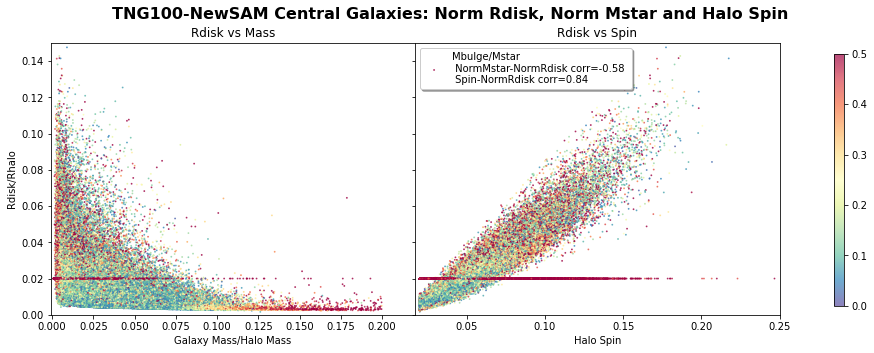

In [68]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle('TNG100-NewSAM Central Galaxies: Norm Rdisk, Norm Mstar and Halo Spin  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = ('Mbulge/Mstar \n NormMstar-NormRdisk corr=-0.58 \n Spin-NormRdisk corr=0.84')
im1 = ax1.scatter(df_normalized.loc[:, 'GalpropNormMstar'], df_normalized.loc[:, 'GalpropNormRdisk'], 
                  c = (df_normalized.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                  cmap='Spectral_r', vmin=0.0, vmax=0.5)

ax1.set_xlim([-0.001, 0.22])
# ax1.set_xticks([0.0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150])
ax1.set_ylim([0.0,0.15])
ax1.set_title('Rdisk vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('Galaxy Mass/Halo Mass')
ax1.set_ylabel('Rdisk/Rhalo')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_normalized.loc[:, 'HalopropSpin'], df_normalized.loc[:, 'GalpropNormRdisk'], 
                    c = (df_normalized.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                    label=label, cmap='Spectral_r', vmin=0.0, vmax=0.5)

     
ax2.set_xlim([0.017,0.25])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Rdisk vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper left' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_NormMstar_NormRdisk_Spin.jpeg", dpi=500)
plt.show()

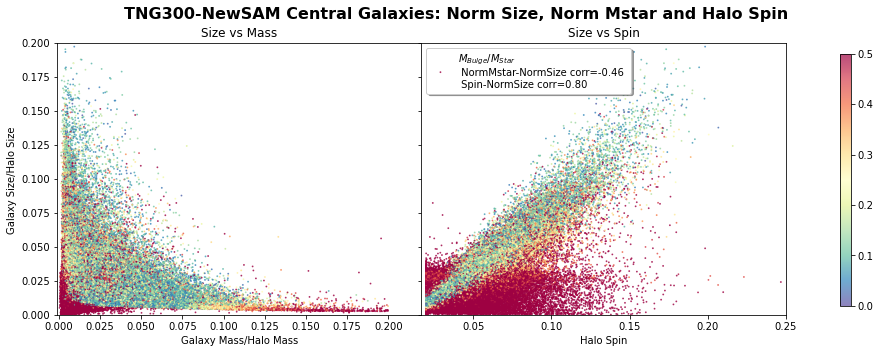

In [71]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle('TNG300-NewSAM Central Galaxies: Norm Size, Norm Mstar and Halo Spin  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = (r'$M_{Bulge}/M_{Star}$' +' \n NormMstar-NormSize corr=-0.46 \n Spin-NormSize corr=0.80')
im1 = ax1.scatter(df_normalized.loc[:, 'GalpropNormMstar'], df_normalized.loc[:, 'GalpropNormHalfRadius'], 
                  c = (df_normalized.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                  cmap='Spectral_r', vmin=0, vmax=0.5)

ax1.set_xlim([-0.001, 0.22])
# ax1.set_xticks([0.0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150])
ax1.set_ylim([0.0, 0.2])
ax1.set_title('Size vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('Galaxy Mass/Halo Mass')
ax1.set_ylabel('Galaxy Size/Halo Size ')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_normalized.loc[:, 'HalopropSpin'], df_normalized.loc[:, 'GalpropNormHalfRadius'], 
                    c = (df_normalized.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                    label=label, cmap='Spectral_r', vmin=0, vmax=0.5)

     
ax2.set_xlim([0.017,0.25])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper left' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_NormaMstar_NormSize_Spin_colorbarBulgeMstar.jpeg", dpi=500)
plt.show()

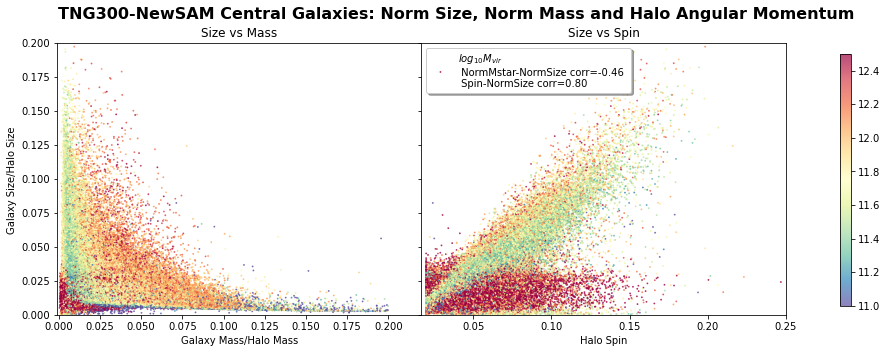

In [73]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle('TNG300-NewSAM Central Galaxies: Norm Size, Norm Mass and Halo Angular Momentum  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = (r'$log_{10}M_{vir}$' +' \n NormMstar-NormSize corr=-0.46 \n Spin-NormSize corr=0.80')
im1 = ax1.scatter(df_normalized.loc[:, 'GalpropNormMstar'], df_normalized.loc[:, 'GalpropNormHalfRadius'], 
                  c = (np.log10(df_not_normalized.loc[:, 'HalopropMvir'])),  s=3, marker='.', alpha=0.7, 
                  cmap='Spectral_r', vmin=11, vmax=12.5)

ax1.set_xlim([-0.001, 0.22])
# ax1.set_xticks([0.0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150])
ax1.set_ylim([0.0, 0.2])
ax1.set_title('Size vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('Galaxy Mass/Halo Mass')
ax1.set_ylabel('Galaxy Size/Halo Size ')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_normalized.loc[:, 'HalopropSpin'], df_normalized.loc[:, 'GalpropNormHalfRadius'], 
                    c = (np.log10(df_not_normalized.loc[:, 'HalopropMvir'])),  s=3, marker='.', alpha=0.7, 
                    label=label, cmap='Spectral_r', vmin=11, vmax=12.5)

     
ax2.set_xlim([0.017,0.25])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Size vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper left' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_NormaMstar_NormSize_Spin_colorbarMvir.jpeg", dpi=500)
plt.show()

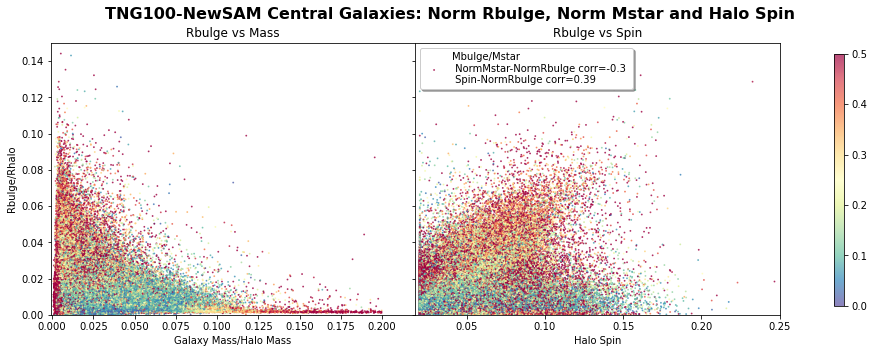

In [77]:
fig,[ax1, ax2]=plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(15,5))
fig.suptitle('TNG100-NewSAM Central Galaxies: Norm Rbulge, Norm Mstar and Halo Spin  ', fontsize=16, fontweight='bold')
plt.subplots_adjust(hspace=0.0,wspace=0.0)

label = ('Mbulge/Mstar \n NormMstar-NormRbulge corr=-0.3 \n Spin-NormRbulge corr=0.39')
im1 = ax1.scatter(df_normalized.loc[:, 'GalpropNormMstar'], df_normalized.loc[:, 'GalpropNormRbulge'], 
                  c = (df_normalized.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                  cmap='Spectral_r', vmin=0.0, vmax=0.5)

ax1.set_xlim([-0.001, 0.22])
# ax1.set_xticks([0.0, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150])
ax1.set_ylim([0.0,0.15])
ax1.set_title('Rbulge vs Mass')
# ax1.set_xlabel('$\log_{10} $  Galaxy Mass $[M_\odot] $')
ax1.set_xlabel('Galaxy Mass/Halo Mass')
ax1.set_ylabel('Rbulge/Rhalo')
# ax1.legend(loc='lower right', shadow=True)
# fig.colorbar(im1, ax=ax1)

im2 = ax2.scatter(df_normalized.loc[:, 'HalopropSpin'], df_normalized.loc[:, 'GalpropNormRbulge'], 
                    c = (df_normalized.loc[:, 'BulgeMstar_ratio']),  s=3, marker='.', alpha=0.7, 
                    label=label, cmap='Spectral_r', vmin=0.0, vmax=0.5)

     
ax2.set_xlim([0.017,0.25])
# ax2.set_xticks([ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
# ax2.set_ylim([-3.0, 1.1])
ax2.set_title('Rbulge vs Spin')
ax2.set_xlabel('Halo Spin')
# ax2.set_ylabel('$\log_{10} \, \, Galaxy Size [kpc]($ Log_{10} $)')
ax2.legend(loc='upper left' , shadow=True)
# fig.colorbar(im2, ax=ax2)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im2, cax=cbar_ax)

# plt.savefig("TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_NormMstar_NormRbulge_Spin.jpeg", dpi=500)
plt.show()

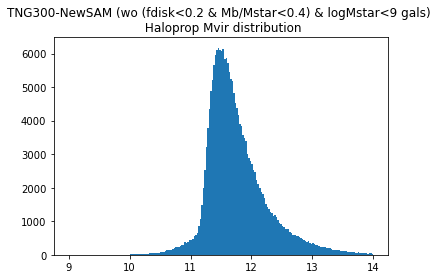

In [57]:
plt.hist(np.log10(df_not_normalized.loc[:, 'HalopropMvir']), range=(9.0, 14.0), bins=200)
plt.title('TNG300-NewSAM (wo (fdisk<0.2 & Mb/Mstar<0.4) & logMstar<9 gals) \n Haloprop Mvir distribution')
# plt.savefig('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300_HalopropMvir_distribution', dpi=500)
plt.show()

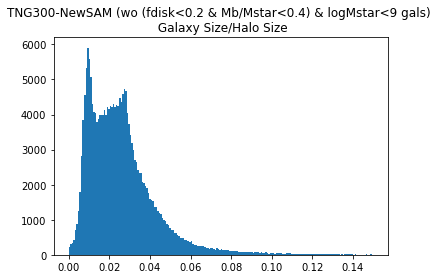

In [58]:
# TNG100-NewSAM half rad distribution
plt.hist(df_normalized.loc[:, 'GalpropNormHalfRadius'], range=(0,0.15), bins=200)
plt.title('TNG300-NewSAM (wo (fdisk<0.2 & Mb/Mstar<0.4) & logMstar<9 gals) \n Galaxy Size/Halo Size')
# plt.savefig('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_NormHalfRad_histogram.jpeg', dpi=500)
plt.show()

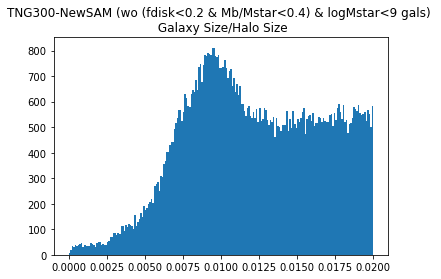

In [59]:
plt.hist(df_normalized.loc[:, 'GalpropNormHalfRadius'], range=(0.0,0.02), bins=200)
plt.title('TNG300-NewSAM (wo (fdisk<0.2 & Mb/Mstar<0.4) & logMstar<9 gals) \n Galaxy Size/Halo Size')
# plt.savefig('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_NormHalfRad_histogram2.jpeg', dpi=500)
plt.show()

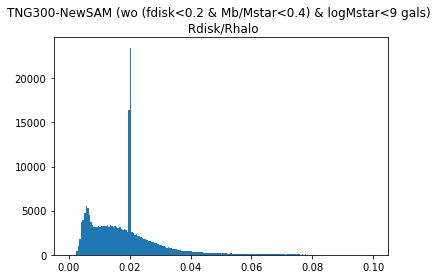

In [80]:
# TNG100-NewSAM half rad distribution
plt.hist(df_normalized.loc[:, 'GalpropNormRdisk'], range=(0,0.1), bins=200)
plt.title('TNG300-NewSAM (wo (fdisk<0.2 & Mb/Mstar<0.4) & logMstar<9 gals) \n Rdisk/Rhalo')
# plt.savefig('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_NormRdisk_histogram.jpeg', dpi=500)
plt.show()

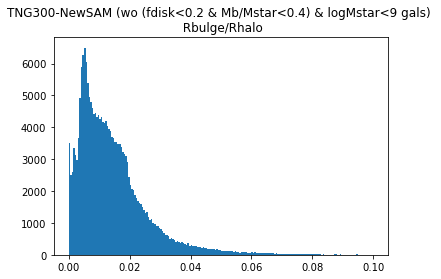

In [83]:
# TNG100-NewSAM half rad distribution
plt.hist(df_normalized.loc[:, 'GalpropNormRbulge'], range=(0,0.1), bins=200)
plt.title('TNG300-NewSAM (wo (fdisk<0.2 & Mb/Mstar<0.4) & logMstar<9 gals) \n Rbulge/Rhalo')
# plt.savefig('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_TNG300-NewSAM_NormRbulge_histogram.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =5> </a> <br> Disks SR eqn Spin/NormVdisk^2 applied on predicting Rdisk/Rhalo rather than R50/Rhalo (NormHalfRadius)

In [13]:
# Combined Disk morphologies 1 to 4 in order to fit one physical model to all of them; 
# 158,501 galaxies in the 1-4 morphologies, out of a total of ~207,000
df_14 = df_normalized.loc[df_normalized.BulgeMstar_ratio <= 0.40] #normalized
# df_14_raw = df_not_normalized.loc[df_not_normalized.BulgeMstar_ratio <= 0.40] 

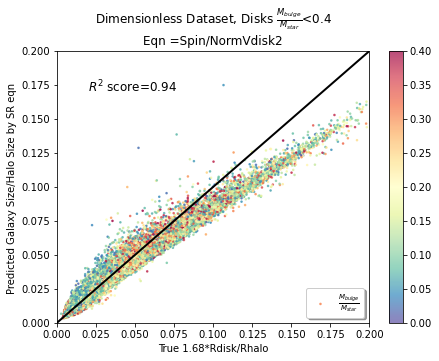

In [91]:

spin_vdisk2_eqn = df_14.loc[:, 'HalopropSpin']/df_14.loc[:, 'GalpropNormVdisk']**2

r2_score_disks=r2_score(1.68*df_14.loc[:, 'GalpropNormRdisk'], spin_vdisk2_eqn)

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(1.68*df_14.loc[:, 'GalpropNormRdisk'], spin_vdisk2_eqn,
            c = df_14.loc[:, 'GalpropNormMbulge']/df_14.loc[:,'GalpropNormMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.4)
ax.text(0.02, 0.17, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_disks), size=12)
ax.axis([0.0,0.2, 0.0,0.2])
ax.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax.set_title(r'Dimensionless Dataset, Disks $\frac{M_{bulge}}{M_{star}}$<0.4' + '\n'+ r'Eqn =Spin/NormVdisk2')
ax.set_xlabel('True 1.68*Rdisk/Rhalo')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Predicted Galaxy Size/Halo Size by SR eqn ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_Group14_SpinNormVdisk2_vs_NormRdisk.jpeg', dpi=500)
plt.show()

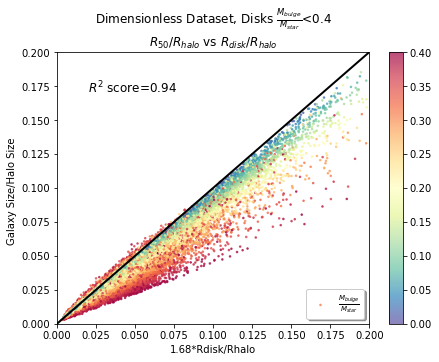

In [16]:

r2_score_RdiskR50=r2_score(1.68*df_14.loc[:, 'GalpropNormRdisk'], df_14.loc[:, 'GalpropNormHalfRadius'])

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(1.68*df_14.loc[:, 'GalpropNormRdisk'], df_14.loc[:, 'GalpropNormHalfRadius'],
            c = df_14.loc[:, 'GalpropNormMbulge']/df_14.loc[:,'GalpropNormMstar'], 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$\frac{M_{bulge}}{M_{star}}$', vmin=0.0, vmax=0.4)
ax.text(0.02, 0.17, r'$R^{2}$ score=' + '{:.2f}'.format(r2_score_RdiskR50), size=12)
ax.axis([0.0,0.2, 0.0,0.2])
ax.plot([0.0, 0.3], [0.0, 0.3], color = 'black', linewidth = 2)
ax.set_title(r'Dimensionless Dataset, Disks $\frac{M_{bulge}}{M_{star}}$<0.4' + '\n'+ r'$R_{50}/R_{halo}$ vs $R_{disk}/R_{halo}$')
ax.set_xlabel('1.68*Rdisk/Rhalo')
ax.legend(loc = 'lower right', shadow=True)
ax.set_ylabel('Galaxy Size/Halo Size  ')
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/v12_Group14_NormR50_vs_NormRdisk.jpeg', dpi=500)
plt.show()

## <font color='purple'> <a id =6> </a> <br> Definition of Morphologies for Rdisk, Rbulge predict dataset & Save Dataset

Same definitions of morphology groups as in Notebook v6. The only difference is that this dataset now contains Rdisk and Rbulge as features.

In [39]:
df_normalized.shape

(207467, 40)

In [40]:
df_not_normalized.shape

(207467, 59)

In [41]:
# 52,053 galaxies in df_1
df_1 = df_normalized.loc[df_normalized.loc[:, 'BulgeMstar_ratio']<=0.10] 
df_1_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']<=0.10] 
# df_1.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_1_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_1_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_1_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_1.shape", df_1.shape)
print("df_1_raw.shape", df_1_raw.shape)

# 64,494 galaxies in df_2
df_2 = df_normalized.loc[(df_normalized.BulgeMstar_ratio > 0.10) & (df_normalized.BulgeMstar_ratio <= 0.20)] 
df_2_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.10) & (df_not_normalized.BulgeMstar_ratio <= 0.20)] 
# df_2.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_2_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_2_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_2_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_2.shape", df_2.shape)
print("df_2_raw.shape", df_2_raw.shape)

# 28,372 galaxies in df_3
df_3 = df_normalized.loc[(df_normalized.BulgeMstar_ratio > 0.20) & (df_normalized.BulgeMstar_ratio <= 0.30)] 
df_3_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.20) & (df_not_normalized.BulgeMstar_ratio <= 0.30)] 
# df_3.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_3_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_3_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_3_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_3.shape", df_3.shape)
print("df_3_raw.shape", df_3_raw.shape)

# 13,582 galaxies in df_4
df_4 = df_normalized.loc[(df_normalized.BulgeMstar_ratio > 0.30) & (df_normalized.BulgeMstar_ratio <= 0.40)] 
df_4_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.30) & (df_not_normalized.BulgeMstar_ratio <= 0.40)] 
# df_4.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_4_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_4_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_4_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_4.shape", df_4.shape)
print("df_4_raw.shape", df_4_raw.shape)

# 13,539 galaxies in df_5
df_5 = df_normalized.loc[(df_normalized.BulgeMstar_ratio > 0.40) & (df_normalized.BulgeMstar_ratio <= 0.50)] 
df_5_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.40) & (df_not_normalized.BulgeMstar_ratio <= 0.50)] 
# df_5.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_5_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_5_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_5_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_5.shape", df_5.shape)
print("df_5_raw.shape", df_5_raw.shape)

# 10,167 galaxies in df_6
df_6 = df_normalized.loc[(df_normalized.BulgeMstar_ratio > 0.50) & (df_normalized.BulgeMstar_ratio <= 0.60)] 
df_6_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.50) & (df_not_normalized.BulgeMstar_ratio <= 0.60)] 
# df_6.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_6_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_6_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_6_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_6.shape", df_6.shape)
print("df_6_raw.shape", df_6_raw.shape)

# 8,367 galaxies in df_7
df_7 = df_normalized.loc[(df_normalized.BulgeMstar_ratio > 0.60) & (df_normalized.BulgeMstar_ratio <= 0.70)] 
df_7_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.60) & (df_not_normalized.BulgeMstar_ratio <= 0.70)] 
# df_7.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_7_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_7_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_7_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_7.shape", df_7.shape)
print("df_7_raw.shape", df_7_raw.shape)

# 6,853 galaxies in df_8
df_8 = df_normalized.loc[(df_normalized.BulgeMstar_ratio > 0.70) & (df_normalized.BulgeMstar_ratio <= 0.80)] 
df_8_raw = df_not_normalized.loc[(df_not_normalized.BulgeMstar_ratio > 0.70) & (df_not_normalized.BulgeMstar_ratio <= 0.80)] 
# df_8.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_8_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_8_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_8_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_8.shape", df_8.shape)
print("df_8_raw.shape", df_8_raw.shape)

# 10,040 galaxies in df_9
df_9 = df_normalized.loc[df_normalized.loc[:, 'BulgeMstar_ratio']>0.80] 
df_9_raw = df_not_normalized.loc[df_not_normalized.loc[:, 'BulgeMstar_ratio']>0.80] 
# df_9.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_9_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_9_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_9_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_9.shape", df_9.shape)
print("df_9_raw.shape", df_9_raw.shape)

# Combined Disk morphologies 1 to 4 in order to fit one physical model to all of them; 
# 158,501 galaxies in the 1-4 morphologies, out of a total of ~207,000
df_14 = df_normalized.loc[df_normalized.BulgeMstar_ratio <= 0.40] #normalized
df_14_raw = df_not_normalized.loc[df_not_normalized.BulgeMstar_ratio <= 0.40] 
# df_14.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_14_Normalized_as_defined_in_TNG300notebook_v12', index=False)
# df_14_raw.to_csv('TNG300-SAM_images/v12_TNG300-SAM_Rdiskpredict_cleanup_normalize_dataset/df_14_Raw_as_defined_in_TNG300notebook_v12', index=False)
print("df_14.shape", df_14.shape)
print("df_14_raw.shape", df_14_raw.shape)

df_1.shape (52053, 40)
df_1_raw.shape (52053, 59)
df_2.shape (64494, 40)
df_2_raw.shape (64494, 59)
df_3.shape (28372, 40)
df_3_raw.shape (28372, 59)
df_4.shape (13582, 40)
df_4_raw.shape (13582, 59)
df_5.shape (13539, 40)
df_5_raw.shape (13539, 59)
df_6.shape (10167, 40)
df_6_raw.shape (10167, 59)
df_7.shape (8367, 40)
df_7_raw.shape (8367, 59)
df_8.shape (6853, 40)
df_8_raw.shape (6853, 59)
df_9.shape (10040, 40)
df_9_raw.shape (10040, 59)
df_14.shape (158501, 40)
df_14_raw.shape (158501, 59)
